# Forward Matrix Calculation with a Custom Forward Projector

This tutorial details the process of calculating a forward matrix ($N_{\text{views}} \times N_{\text{rows}} \times N_{\text{cols}} \times N_E$), making use of xspec.calc_forward_matrix with input:
- A list of scanned materials, accompanied by their densities.
- Masks representing homogeneous objects to depict object dimensions.
- A CT forward projector encapsulated within a Python class.

The specified CT forward projector is designed for executing forward projections of the provided masks, thereby calculating the line path that traverses a homogeneous object in millimeters.

## A. Cacluate A list of scanned materials, accompanied by their densities.
Obtain LAC $\mu(E)$ for each scanned homogeneous object with `get_lin_att_c_vs_E`:
Note that, we provide a reference density for elementary substance. However, the reference density is not available for compounds.

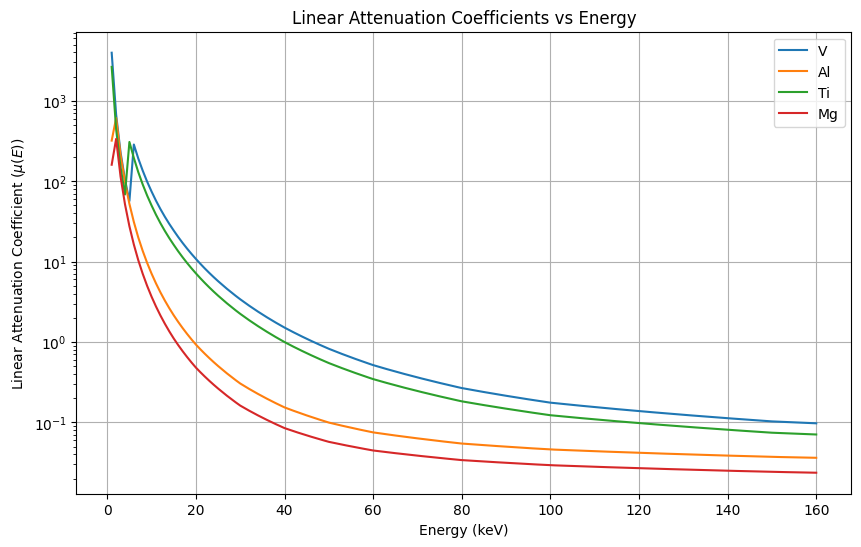

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from xspec.chem_consts import get_lin_att_c_vs_E
from xspec.chem_consts._periodictabledata import density

# Scanned cylinders
materials = ['V', 'Al', 'Ti', 'Mg']
mat_density = [density['%s' % formula] for formula in materials]
energies = np.linspace(1, 160, 160) # Define energies bins from 1 kV to 160 kV with step size 1 kV.
lac_vs_E_list = []

for i in range(len(materials)):
    formula = materials[i]
    den = mat_density[i]
    lac_vs_E_list.append(get_lin_att_c_vs_E(den, formula, energies))
    
plt.figure(figsize=(10, 6))

for i, lac in enumerate(lac_vs_E_list):
    plt.plot(energies, lac, label=materials[i])

plt.xlabel('Energy (keV)')
plt.ylabel('Linear Attenuation Coefficient ($\mu(E)$)')
plt.title('Linear Attenuation Coefficients vs Energy')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

## B. Masks for homogeneous objects

This script demonstrates how to generate **a simulated list of 3D masks for homogenous samples**. 
The script uses the Gen_Circle class to generate each 3D mask and then calculates the LAC at a specific energy level (60 keV) for each material. 
The final output is a visual representation of the summed LAC across all cylindrical objects, providing insight into how different materials within a composite object might interact with X-ray photons at a given energy level.

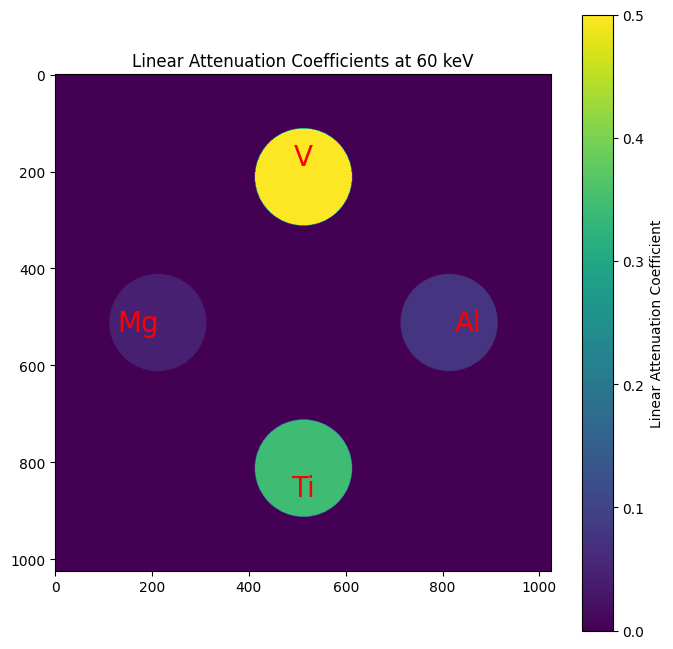

In [2]:
from xspec._utils import Gen_Circle
from xspec.chem_consts import get_lin_att_c_vs_E

# FOV is about 10 mm * 10 mm
nchanl = 1024
rsize = 0.01  # mm

# 4 cylinders with 1mm radius are evenly distributed on a circle with 3mm radius.
Radius = [1 for _ in range(len(materials))]
arrange_with_radius = 3 
centers = [[np.sin(rad_angle) * arrange_with_radius, np.cos(rad_angle) * arrange_with_radius]
		   for rad_angle in np.linspace(-np.pi / 2, -np.pi / 2 + np.pi * 2, len(materials), endpoint=False)]

# Each mask represents a homogenous cylinder.
mask_list = []
for mat_id, mat in enumerate(materials):
	circle = Gen_Circle((nchanl, nchanl), (rsize, rsize))
	# Use np.newaxis to convert 2D array to 3D.
	mask_list.append(circle.generate_mask(Radius[mat_id], centers[mat_id])[np.newaxis])

# Calculate the summed LAC for all materials at 60 keV
summed_lac = np.sum(
    np.array([ml * get_lin_att_c_vs_E(mat_density[i], materials[i], 60.0) for i, ml in enumerate(mask_list)]),
    axis=(0, 1))

# Plotting the result
plt.figure(figsize=(8, 8))
plt.imshow(summed_lac, vmin=0, vmax=0.5, cmap='viridis')
plt.colorbar(label='Linear Attenuation Coefficient')
plt.title('Linear Attenuation Coefficients at 60 keV')

# Adding labels for each material at its center
for i, center in enumerate(centers):
    plt.text(center[1] * nchanl/9 + nchanl/2, center[0] * nchanl/9 + nchanl/2, materials[i], color='red', ha='center', va='center', fontsize=20)

plt.show()

## C. A CT forward projector encapsulated within a Python class
Before you start, ensure you have the following prerequisites installed:

- SVMBIR (for forward projection, you can use your own forward projector)

The custom forward projector should be encapsulated within a python class `fw_projector` . This class is designed to initialize with specific parameters that outline the CT geometry. It features a forward function dedicated to executing the projection of a specified mask.

In the ensuing example, we encapsulate the `svmbir.project` function within a python class `fw_projector` class. The process involves two principal steps:

1. Initializing the class with essential geometric parameters through the `__init__()` method.

2. Crafting a `forward(self, mask)` method that computes and returns the projection ($N_{\text{views}} \times N_{\text{rows}} \times N_{\text{cols}}$) of a 3D mask.


In [3]:
import svmbir

class fw_projector:
    """A class for forward projection using SVMBIR."""

    def __init__(self, angles, num_channels, delta_pixel=1):
        """
        Initializes the forward projector with specified geometric parameters.

        Parameters:
            angles (array): Array of projection angles.
            num_channels (int): Number of detector channels.
            delta_pixel (float, optional): Size of a pixel, defaults to 1.
        """
        self.angles = angles
        self.num_channels = num_channels
        self.delta_pixel = delta_pixel

    def forward(self, mask):
        """
        Computes the projection of a given mask.

        Parameters:
            mask (numpy.ndarray): 3D mask of the object to be projected.

        Returns:
            numpy.ndarray: The computed projection of the mask.
        """
        projections = svmbir.project(mask, self.angles, self.num_channels) * self.delta_pixel
        return projections
    
angles = np.linspace(-np.pi/2, np.pi, 40, endpoint=False)
projector = fw_projector(angles, num_channels=1024, delta_pixel=0.01)

## Calculating the Forward Matrix

Calculate the forward matrix ($N_{\text{views}} \times N_{\text{rows}} \times N_{\text{cols}} \times N_E$) using the list of masks, LAC, and projector using `calc_forward_matrix`:


In [4]:
from xspec import calc_forward_matrix
spec_F = calc_forward_matrix(mask_list, lac_vs_E_list, projector)
print('Shape of spec_F', spec_F.shape)

Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/fa02df7dd8cb1ddb5e4d.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/fa02df7dd8cb1ddb5e4d.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/fa02df7dd8cb1ddb5e4d.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/fa02df7dd8cb1ddb5e4d.2Dsvmatrix
Shape of spec_F (40, 1, 1024, 160)


Text(0.5, 1.0, 'Transmission Value at -76.50 Degrees for 60 keV')

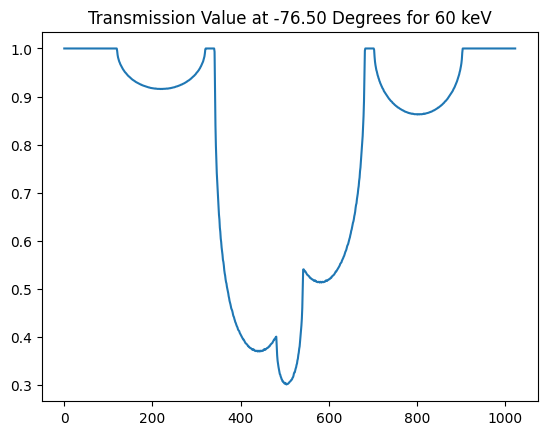

In [5]:
plt.plot(spec_F[2,0,:,60])
plt.title(f'Transmission Value at {np.degrees(angles[2]):.2f} Degrees for 60 keV')